In [2]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-09-07 06:32:31.359088


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


--2024-09-07 06:32:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-07 06:32:32 (65.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-09-07 06:32:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 74.125.141.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   152MB/s    in 1.1s    

2024-09-07 06:32:41 (152 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
train_dir='10_food_classes_10_percent/train'
test_dir= '10_food_classes_10_percent/test'

In [6]:
walk_through_dir("101_food_classes_10_percent")


In [7]:
import tensorflow as tf
IMG_SIZE= (224,224)
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**feature extraction**

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  # specify the filepath
    save_weights_only=True,  # save only the model weights
    monitor="val_accuracy",  # save the model weights which score the best validation accuracy
    save_best_only=True,  # only keep the best model weights on file (delete the rest)
    mode="max"  # specify the mode for monitoring (max for accuracy)
)

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal", name="random_flip"),
  layers.RandomRotation(0.2, name="random_rotation"),
  layers.RandomZoom(0.2, name="random_zoom"),
  layers.RandomHeight(0.2, name="random_height"),
  layers.RandomWidth(0.2, name="random_width"),
  ], name="data_augmentation_layer")

In [11]:

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation_layer (Sequential) │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file


Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.1829 - loss: 2.2256 - val_accuracy: 0.4688 - val_loss: 1.6997
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.6496 - loss: 1.4974 - val_accuracy: 0.8210 - val_loss: 0.9540
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.6939 - loss: 1.1972 - val_accuracy: 0.7443 - val_loss: 1.0531
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.7347 - loss: 1.0305 - val_accuracy: 0.8125 - val_loss: 0.7760
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7778 - loss: 0.8794 - val_accuracy: 0.8977 - val_loss: 0.5421


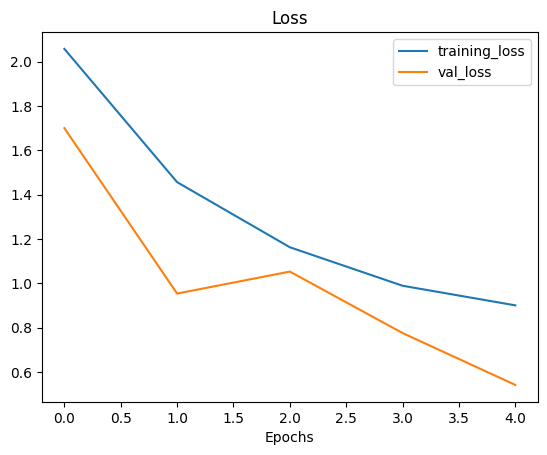

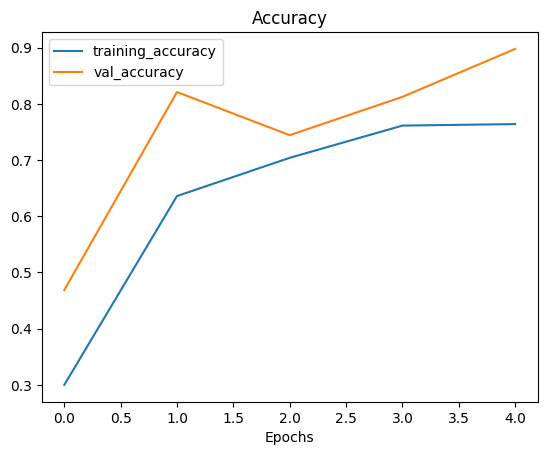

In [15]:
plot_loss_curves(history_all_classes_10_percent)


**Fine-tuning**

In [16]:
base_model.trainable=True

In [18]:
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [20]:
model.compile(loss= 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling True
output_layer True


In [29]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [32]:
fine_tune_epochs=10
history_all_classes_10_percent_fine_tune = model.fit(
   train_data_all_10_percent,
   epochs=fine_tune_epochs,
   validation_data= test_data,
   validation_steps = int(0.15 * len(test_data)),
  initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7561 - loss: 0.8812 - val_accuracy: 0.6648 - val_loss: 0.9618
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.8401 - loss: 0.7289 - val_accuracy: 0.8665 - val_loss: 0.5001
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.7977 - loss: 0.7754 - val_accuracy: 0.7642 - val_loss: 0.7441
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.8293 - loss: 0.6239 - val_accuracy: 0.8239 - val_loss: 0.6171
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.8190 - loss: 0.6387 - val_accuracy: 0.8892 - val_loss: 0.3972
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8631 - loss: 0.5834 - val_accuracy: 0.8636 - val_loss: 0.3955


In [33]:
results_all_classes_10_percent_fine_tune =model.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.7989 - loss: 0.6388


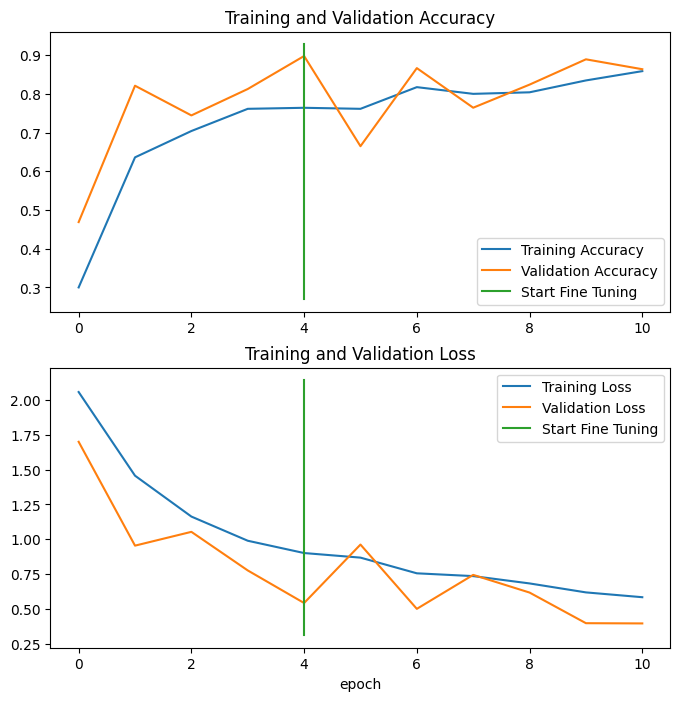

In [34]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [38]:
pred_probs= model.predict(test_data,verbose=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step


In [39]:
len(pred_probs)

2500

In [40]:
pred_probs.shape

(2500, 10)

In [44]:
y_labels = []

for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]
pred_classes= pred_probs.argmax(axis=1)
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8196